In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
data = pd.read_parquet('train.parquet')

In [35]:
# Вытянем все данные из датафрейма
exploded_df = data.explode(['dates', 'values'], ignore_index=True)
exploded_df

,id,dates,values,label
0,19114,2016-01-01,-1.86,0.0
1,19114,2016-02-01,0.79,0.0
2,19114,2016-03-01,1.4,0.0
3,19114,2016-04-01,0.15,0.0
4,19114,2016-05-01,0.0,0.0
...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0
5155408,98870,2019-12-01,0.26335,1.0
5155409,98870,2020-01-01,-1.73665,1.0
5155410,98870,2020-02-01,-0.38665,1.0


<Axes: xlabel='dates', ylabel='values'>

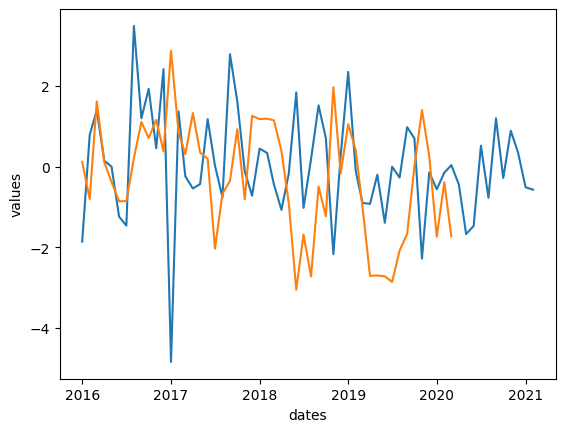

In [34]:
# Посмотрим на временные ряды
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x='dates', y='values', data=exploded_df[exploded_df['id'] == 19114])
sns.lineplot(x='dates', y='values', data=exploded_df[exploded_df['id'] == 98870])

На глаз ничего не видно, поэтому попробуем вытащить статистику из рядов.

In [39]:
data.isna().sum()

id        0
dates     0
values    0
label     0
dtype: int64

In [40]:
exploded_df.isna().sum()

id           0
dates        0
values    4582
label        0
dtype: int64

In [ ]:
# Будем осторожны при работе с данными, так как там есть пропуски

In [ ]:
# Вытаскиваем признаки из временного ряда
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Функция для извлечения статистических признаков из временного ряда
def extract_features(values):
    features = {}
    # Статистические признаки
    features['mean'] = np.mean(values)
    features['std'] = np.std(values)
    features['var'] = np.var(values)
    features['min'] = np.min(values)
    features['max'] = np.max(values)
    features['median'] = np.median(values)
    features['25_quantile'] = np.percentile(values, 25)
    features['50_quantile'] = np.percentile(values, 50)  # То же, что и медиана
    features['75_quantile'] = np.percentile(values, 75)
    features['range'] = np.max(values) - np.min(values)
    features['sum'] = np.sum(values)
    features['last_value'] = values[-1]
    
    # Дополнительные признаки
    features['first_value'] = values[0]
    features['sum_first_5'] = np.sum(values[:5]) if len(values) >= 5 else np.sum(values)
    features['sum_last_5'] = np.sum(values[-5:]) if len(values) >= 5 else np.sum(values)
    
    # Коэффициент вариации
    features['coef_variation'] = np.std(values) / np.mean(values) if np.mean(values) != 0 else 0
    
    # Автокорреляция с лагом 1
    features['autocorr_lag1'] = pd.Series(values).autocorr(lag=1)
    
    return features

# Функция для извлечения временных признаков из дат
def extract_time_features(dates):
    features = {}
    # Преобразование списка дат в формат datetime
    dates = pd.to_datetime(dates)
    
    # Временные признаки
    features['date_start_month'] = dates[0].month
    features['date_end_month'] = dates[-1].month
    features['date_range_days'] = (dates[-1] - dates[0]).days  # Длина временного ряда в днях
    
    # Признаки дня недели
    features['start_day_of_week'] = dates[0].weekday()  # День недели начала ряда
    features['end_day_of_week'] = dates[-1].weekday()  # День недели конца ряда
    
    return features

# Преобразование каждого ряда в набор признаков
rows = []
for _, row in data.iterrows():
    value_features = extract_features(row['values'])
    time_features = extract_time_features(row['dates'])
    combined_features = {**value_features, **time_features, 'label': row['label']}
    rows.append(combined_features)

# Преобразование в новый DataFrame
df_features = pd.DataFrame(rows)


Этот код извлекает различные статистические и временные признаки из временных рядов. Вот описание каждого извлекаемого признака:

1. Статистические признаки (из столбца values)
- mean: Среднее значение временного ряда.
- std: Стандартное отклонение временного ряда.
- var: Дисперсия временного ряда.
- min: Минимальное значение в ряду.
- max: Максимальное значение в ряду.
- median: Медиана временного ряда.
- 25_quantile: 25-й процентиль (нижний квартиль).
- 50_quantile: 50-й процентиль (то же, что и медиана).
- 75_quantile: 75-й процентиль (верхний квартиль).
- range: Размах — разница между максимальным и минимальным значениями.
- sum: Сумма всех значений ряда.
- last_value: Последнее значение в ряду.
- first_value: Первое значение в ряду.
- sum_first_5: Сумма первых пяти значений ряда.
- sum_last_5: Сумма последних пяти значений ряда.
- coef_variation: Коэффициент вариации (отношение стандартного отклонения к среднему).
- autocorr_lag1: Автокорреляция с лагом 1 (насколько текущее значение связано с предыдущим).
2. Временные признаки (из столбца dates)
- date_start_month: Месяц начала временного ряда.
- date_end_month: Месяц окончания временного ряда.
- date_range_days: Длина временного ряда в днях (разница между последней и первой датой).
- start_day_of_week: День недели начала ряда (0 — понедельник, 6 — воскресенье).


In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

df_features.dropna(inplace=True)
# Определение признаков (features) и меток (label)
X = df_features.drop('label', axis=1)

y = df_features['label']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Словарь для хранения моделей
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Stochastic Logistic Regression': SGDClassifier(loss='log_loss', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Classifier': SVC(probability=True, random_state=42),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Словарь для хранения ROC AUC
roc_auc_scores = {}

# Обучение моделей и расчет ROC AUC
for name, model in models.items():
    model.fit(X_train, y_train)  # Обучение модели
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Предсказание вероятностей
    roc_auc = roc_auc_score(y_test, y_pred_proba)  # ROC AUC
    roc_auc_scores[name] = roc_auc  # Сохранение результата

# Вывод ROC AUC для каждой модели
for model_name, score in roc_auc_scores.items():
    print(f'{model_name}: ROC AUC = {score:.4f}')


C:\Users\1\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\1\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:20:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression: ROC AUC = 0.4854
Stochastic Logistic Regression: ROC AUC = 0.3007
Random Forest: ROC AUC = 0.9011
Decision Tree: ROC AUC = 0.7376
Support Vector Classifier: ROC AUC = 0.5002
KNeighbors Classifier: ROC AUC = 0.8019
Gradient Boosting: ROC AUC = 0.9026
AdaBoost: ROC AUC = 0.8918
XGBoost: ROC AUC = 0.9055


Выбираем модель XGBoost и будем её улучшать

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Определение признаков (features) и меток (label)
X = df_features.drop('label', axis=1)
y = df_features['label']

from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Функция оптимизации для Optuna
def objective(trial):
    # Гиперпараметры для подбора
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # Обучение модели с текущими гиперпараметрами
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Предсказание вероятностей на тестовой выборке
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Вычисление метрики ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc

# Оптимизация с использованием Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Лучшие гиперпараметры
best_params = study.best_params
print("Best ROC AUC score:", study.best_value)
print("Best parameters:", best_params)

# Обучение модели с лучшими гиперпараметрами
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train, y_train)

# Оценка качества модели на тестовых данных
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC на тестовых данных: {roc_auc:.4f}")


На этом исследовательская часть закончена, далее код был разнесён по скриптам.